In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.losses import mse

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

from scipy.spatial.distance import pdist

%matplotlib inline
import mpld3
mpld3.enable_notebook()

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    y = [np.empty((len(x[0]), output_.get_shape()[1])) for output_ in K_fn.outputs]
    recon_means = []
    for i in range(int(x[0].shape[0]/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, alpha1=0.5, alpha2=None, label1=None, label2=None, cmap1=None, cmap2=None):
    n = x.shape[1]
    alpha2 = alpha1 if alpha2 is None else alpha2
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha1, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s, alpha=alpha2, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha1, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s, alpha=alpha2, label=label2)
    elif n == 784:
        %matplotlib inline
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha1, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s, alpha=alpha2, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [4]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=200, train_set_fraction=.8, alpha=4, uniform=False):
    if uniform:
        t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
    else:
        t = np.log(np.linspace(0, 2*np.pi, num=n+1)[:-1])
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [64]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 10
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=1, train_set_fraction=0.85)
    latent_dim = 6
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=2000, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.1, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=256, train_set_fraction=0.85, alpha=30)
    latent_dim = 3

x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)
    
# normalize to between -1 and 1
if dataset != 'mnist':
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

arch = [
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 512},
    {'type': 'linear', 'size': 16},
    ]

IMPORTANT: max 1.0, min -1.0


In [107]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
#     output = z_mean + K.exp(0.5 * z_log_var) * epsilon
    output = z_mean
    print(z_log_var.shape, epsilon.shape, batch, dim)
    temp = K.exp(0.5 * z_log_var) * epsilon
    output = output + temp
    return output

class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            latent_dim, orig_dim, affinity, scale_nbr, n_nbrs, batch_sizes, beta=1, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        self.latent_dim = latent_dim
        self.orig_dim = orig_dim
        # generate layers
        self.main_layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.main_layers += [
                  {'type': 'tanh',
                   'size': self.latent_dim,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]
        self.sigma_layers = make_layer_list(arch[:-1], 'sigma', spec_reg)
        self.sigma_layers += [
                  {'type': 'linear',
                   'size': self.latent_dim,
                   'l2_reg': spec_reg,
                   'name': 'sigma_{}'.format(len(arch)-1)},
                  ]

        # create encoder
        all_outputs = stack_layers(self.inputs, self.main_layers, return_all_layers=True)
        self.encoder_outputs = all_outputs[-1]
        self.mu = self.encoder_outputs['Unlabeled']
        self.log_var = stack_layers({'Unlabeled': all_outputs[-2]['Unlabeled']}, self.sigma_layers)['Unlabeled']
        self.z = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([self.mu, self.log_var])
        self.encoder = Model(inputs=self.inputs['Unlabeled'], outputs=[self.z, self.mu, self.log_var])
        
        # create decoder
        self.decoder_input = Input(shape=(self.latent_dim,), name='DecoderInput')
        self.decoder_layers = make_layer_list(arch[-2::-1], 'decoder', spec_reg)
        self.decoder_layers += [
                  {'type': 'linear',
                   'size': self.orig_dim,
                   'l2_reg': spec_reg,
                   'name': 'sigma_{}'.format(len(arch)-1)},
                  ]
        self.decoder_output = stack_layers({'Unlabeled': self.decoder_input}, self.decoder_layers)['Unlabeled']
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)
        self.x_hat = self.decoder(self.z)
        
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.z)
        
        # DEFINE VAE LOSS
        alpha = 1
        alpha = float(alpha)
        # alpha = K.sum((self.mu - K.mean(self.mu, axis=0))**2)
        reconstruction_loss = K.sum(mse(self.x_hat, self.inputs['Unlabeled']), axis=-1) * self.orig_dim
        kl_loss = -1 + K.log(alpha) - self.log_var + K.exp(self.log_var)/alpha
        kl_loss = K.sum(kl_loss, axis=-1) * 0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)

        # DEFINE SPECTRAL LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            y_ = tf.concat([self.encoder_outputs['Unlabeled'], self.encoder_outputs['Labeled']], axis=0)
        else:
            y_ = self.encoder_outputs['Unlabeled']
            
        if self.normalized:
            y_old = y_
            y_ = y_ / tf.expand_dims(tf.reduce_sum(W, axis=1), axis=-1)
        
        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled']) + beta * vae_loss

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
#         self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        
        # initialize spectralnet variables
        K.get_session().run(tf.initializers.global_variables())

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]
    
    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.mu,
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)
    
    def generate_from_samples(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.x_hat,
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [108]:
split = int(len(x_train)*0.8)
x_train, x_val = x_train[:split], x_train[split:]
y_train, y_val = y_train[:split], y_train[split:]

In [109]:
n_clusters = latent_dim

bsize = 32

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape,name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape,name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape,name='OrthonormInput'),
    }
k = 2
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, input_shape[0], affinity='full', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, beta=0.1, siamese_net=None, 
            x_train=x_train, have_labeled=len(x_train))

(?, 3) (?, 3) Tensor("z_21/strided_slice:0", shape=(), dtype=int32) 3


In [111]:
spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=5e-5, drop=0.1, patience=30, num_epochs=100)

Epoch: 0, loss=423.361491, val_loss=41.899845
Epoch: 1, loss=429.704974, val_loss=41.207542
Epoch: 2, loss=429.131130, val_loss=41.912796
Epoch: 3, loss=426.071674, val_loss=41.649727
Epoch: 4, loss=423.098460, val_loss=41.140446
Epoch: 5, loss=426.621466, val_loss=41.980644
Epoch: 6, loss=428.806191, val_loss=41.322998
Epoch: 7, loss=429.687341, val_loss=41.062756
Epoch: 8, loss=418.915855, val_loss=41.535912
Epoch: 9, loss=427.079148, val_loss=41.109543
Epoch: 10, loss=430.912943, val_loss=41.385548
Epoch: 11, loss=425.354069, val_loss=41.433113
Epoch: 12, loss=428.986370, val_loss=41.554512
Epoch: 13, loss=425.036456, val_loss=41.753960
Epoch: 14, loss=415.964685, val_loss=40.732933
Epoch: 15, loss=421.946724, val_loss=41.406628
Epoch: 16, loss=428.965213, val_loss=41.541111
Epoch: 17, loss=426.139736, val_loss=41.411373
Epoch: 18, loss=425.203920, val_loss=41.148392
Epoch: 19, loss=426.694804, val_loss=41.378151
Epoch: 20, loss=425.976348, val_loss=41.674728
Epoch: 21, loss=423.944

(array([423.36149073, 429.70497417, 429.13113046, 426.07167387,
        423.09846044, 426.6214664 , 428.80619121, 429.68734074,
        418.91585541, 427.07914805, 430.91294312, 425.35406947,
        428.98637033, 425.03645587, 415.96468472, 421.94672394,
        428.96521258, 426.1397357 , 425.20392036, 426.69480419,
        425.9763484 , 423.94416618, 424.96443462, 427.85591078,
        430.78329229, 424.31749082, 424.04753065, 428.43090391,
        426.76499486, 422.49214315, 423.47061944, 425.35044146,
        418.93860078, 421.85186267, 422.57126355, 423.37912416,
        425.02777505, 422.72285342, 425.5971005 , 425.62502837,
        425.39879513, 424.88675904, 426.45950127, 421.2494173 ,
        430.95472574, 423.25207782, 423.48191237, 423.67556834,
        423.84736776, 424.59649348, 425.34446597, 421.13332415,
        421.13361263, 427.57537484, 422.10382056, 425.39336967,
        422.60990667, 420.09739542, 421.329247  , 425.63951945,
        422.88970017, 425.62680745, 426.

<IPython.core.display.Javascript object>


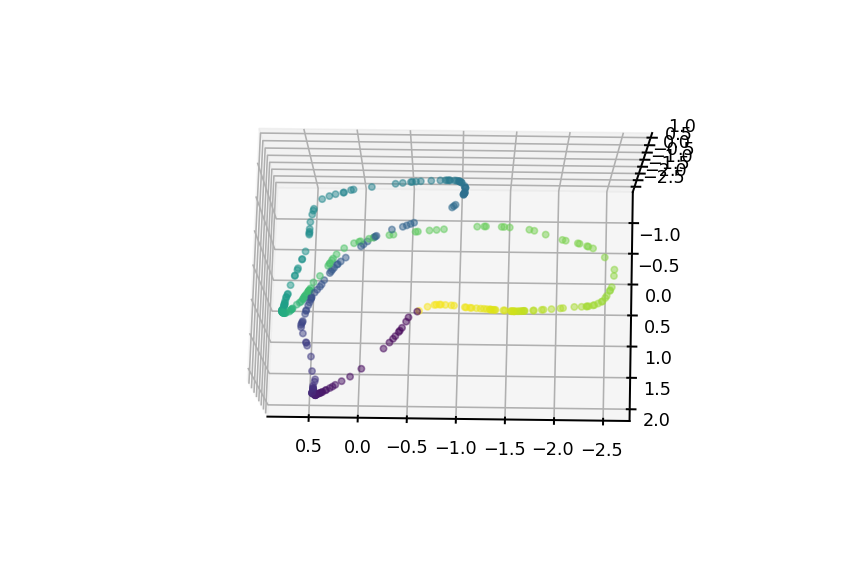

range of y_pred values: 1.951033592224121 - -2.6419994831085205


In [114]:
y_pred = spectral_net.predict(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

<IPython.core.display.Javascript object>


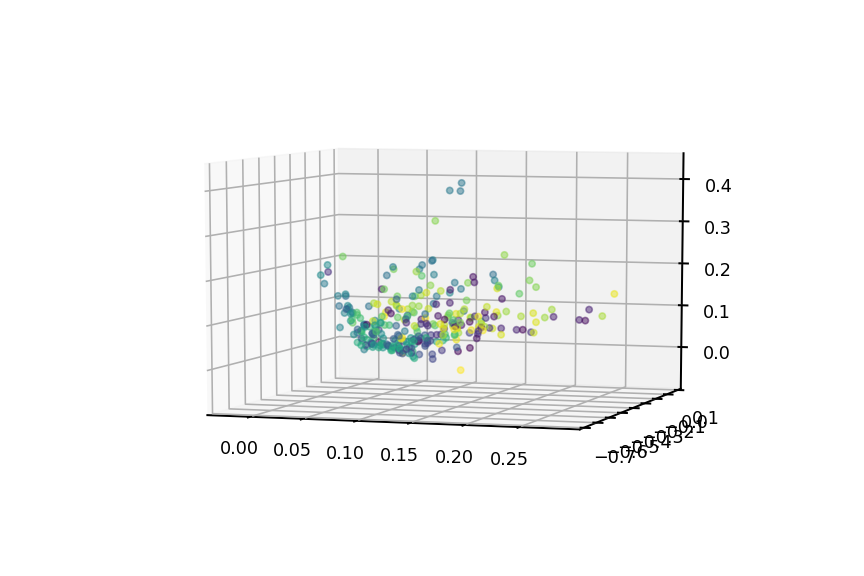

range of y_pred values: 0.42505624890327454 - -0.6757448315620422


In [115]:
y_pred = spectral_net.generate_from_samples(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

In [ ]:
# # now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

In [ ]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], latent_dim=latent_dim)

In [ ]:
svg.train_gan(x_train, epochs=100, n_critic=10, n_vae=50)

In [ ]:
%matplotlib

In [ ]:
x_gen = svg.generate_from_samples(x_train)
g = plot(x_gen, y_train)

In [ ]:
n_samples = 100
n_items = 1
x_gen = np.zeros((n_samples*n_items, x_train.shape[1]))
y_gen = np.zeros((n_samples*n_items,))
step = int(len(x_test) / n_items)
for i in range(n_samples):
    for n in range(n_items):
#         print(n_items*i + n, n*step, step)
        x_gen[n_items*i + n,:] = x_test[n*step,:]
        y_gen[n_items*i + n] = y_test[n*step]
    
x_gen = svg.generate_from_samples(x_gen)
g = plot(x_gen[:, :3], y_gen)

In [ ]:
x = svg.generate_from_samples(x_test)
if dataset == 'mnist':
    n_imgs = 10
    # num = 7
    # sub = y_test == num
    sub = y_test == y_test
    for i in range(n_imgs):
        idx = np.random.randint(len(x[sub]))
        plt.subplot(1,2,1)
        plt.imshow(x_test[sub][idx].reshape(28, 28))
        plt.subplot(1,2,2)
        plt.imshow(x[sub][idx].reshape(28, 28))
        plt.figure()
else:
    x = svg.generate_from_samples(x_test)
    plot(x, y_test)

In [ ]:
# get number of neighbors within one standard deviation of each element in x_test
get_distr = K.function([svg.input], [svg.sigma, svg.mu])
_sigma, _mu = predict_with_K_fn(get_distr, x_test)
_sigma = np.exp(_sigma)

num_close = []
for i in range(len(_sigma)):
    s, m = _sigma[i,:], _mu[i,:]
    scaled_dists = (_mu - m)/s
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test[less_than_std] == y_test[i]), (y_test[less_than_std] != y_test[i])
    num_close.append((np.sum(same), np.sum(diff)))

In [ ]:
perturbed_x = _mu + _sigma * np.random.normal(size=_mu.shape)
g = plot(perturbed_x[:,:2][y_test.astype(np.bool)], x2=(perturbed_x[:,:2])[(1 - y_test).astype(np.bool)])

In [ ]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
B = tf.diag(tf.exp(tf.reduce_sum(svg.sigma, axis=0)) ** 2)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

In [ ]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec = svg.generate_from_samples(x_arr)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst"
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [ ]:
cov_burst

In [ ]:
cov_grad

In [ ]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

In [ ]:
g = plot(x_rec, x2=x_test, label1='true', label2='predicted')

In [ ]:
x__ = np.expand_dims(x_, axis=0)
g = plot(x__, x2=x_test, alpha=.1, label1='true', label2='predicted')

In [ ]:
g = plot(x_test)

In [ ]:
# RANDOM WALK
def walk(f, x_arr, branch_factor=5, n_steps=20, max_size=1000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_.shape[0]])
        (x_arr, x_mu, x_sigma) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, x_mu, x_sigma = x_arr[p], x_mu[p], x_sigma[p]
        
    return x_arr, x_mu, x_sigma

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)
y_test_sz = np.mean(f(x_all)[2], axis=1)
print(y_test_sz)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(y_test_sz)

In [ ]:
import matplotlib.animation
import pandas as pd
from functools import partial

# which space do we want to plot in?
plot_latent = False
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, x_mu, x_sigma = f(x_arr)
    # plot in latent or original space
    x_ = x_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
    ax.view_init(elev=10, azim=num*4)
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Walk, time=0')

graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 90, 
                               interval=100, blit=False)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video(embed_limit=None))

In [ ]:
# TEST BILIP CONDITION
k_nbrs = 5
n_draws = 10
from annoy import AnnoyIndex
t = AnnoyIndex(x_all.shape[1])

K1s = []
K2s = []

x_shuffled = np.random.permutation(x_all)
# p = np.argsort(y_all)
# x_shuffled = x_all[p]
# y_shuffled = y_all[p]
for i, x_i in enumerate(x_shuffled):
    t.add_item(i, x_i)
    
t.build(10)
for i, x_i in enumerate(x_shuffled):
    a = t.get_nns_by_item(i, k_nbrs)
    nbrs = x_shuffled[a]
    A = np.cov(nbrs.T) * 50
    # generate a gaussian from the covariance (TEST)
    # d = x_i + np.random.normal(size=(n_draws, x_all.shape[1])).dot(A)
    d_latent = pdist(f(nbrs)[1])
    d_orig = pdist(nbrs)
    K1s.append(np.max(d_latent/d_orig))
    K2s.append(np.max(d_orig/d_latent))
    if np.isinf(K1s[-1]) or np.isinf(K2s[-1]):
        print("breaking", i)
        break
# g = plot(d, x2=x_shuffled, alpha1=1, alpha2=.1)

In [ ]:
print(d_latent)

In [ ]:
print('K1s', np.min(K1s), np.max(K1s))
print('K2s', np.min(K2s), np.max(K2s))

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)

x_test_sample = np.random.permutation(x_test)[:10]
x_arr, x_sigma, x_mu = walk(f, x_test_sample)

In [ ]:
g = plot(x_arr, x2=x_test, label1='predicted', label2='true')

In [ ]:
# g = plot(x_mu, x2=f(x_test_sample)[1])
g = plot(x_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr)